In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


some imports for the calculations and visualisations

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
plt.style.use("ggplot")
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams['figure.figsize'] = (10, 8)

In [47]:
class GridWorld:

    def __init__(self, GridSize=5, DiscountFactor=0.95):
        self.GridSize = GridSize
        self.States = [(i, j) for i in range(GridSize) for j in range(GridSize)]
        self.DiscountFactor = DiscountFactor
        self.Actions = ['Up', 'Down', 'Left', 'Right']
        self.TransitionProb = 1.0 / len(self.Actions)  # Equal probability for random policy


        self.BlueState = (0, 1)      # High reward state (+5)
        self.GreenState = (0, 3)     # Medium reward state (+2.5)
        self.RedState = (4, 1)       # Target state for blue square
        self.YellowState = (4, 4)    # Regular state in bottom-right

    def GetNextState(self, State, Action):

        i, j = State

        # special reward states first
        if State == self.BlueState:
            return self.RedState, 5.0  # Blue square jumps to red with reward +5

        if State == self.GreenState:
            # Green square: 50% chance to jump to (2,3) or (4,1) with reward +2.5
            if np.random.random() < 0.5:
                return (2, 3), 2.5
            else:
                return self.RedState, 2.5


        NewI, NewJ = i, j
        #preventing movements beyond the boundaries
        if Action == 'Up':
            NewI = max(i-1, 0)          #  top boundary
        elif Action == 'Down':
            NewI = min(i+1, self.GridSize-1)    # bottom boundary
        elif Action == 'Left':
            NewJ = max(j-1, 0)          #  left boundary
        elif Action == 'Right':
            NewJ = min(j+1, self.GridSize-1)    #  right boundary

        #  reward based on movement outcome
        if (NewI, NewJ) == (i, j) and self._IsBoundaryState(State):
            # Atempt to move off grid from boundary position
            Reward = -0.5
        else:
            # Normal movement within grid
            Reward = 0.0

        return (NewI, NewJ), Reward

    def _IsBoundaryState(self, State): # Determines if a state is on the boundary of the grid.

        i, j = State
        return i == 0 or i == self.GridSize-1 or j == 0 or j == self.GridSize-1

# Initialize the GridWorld environment for subsequent analysis
Environment = GridWorld()

print(f"Available actions: {Environment.Actions}")
print(f"Special states defined: Blue {Environment.BlueState}, Green {Environment.GreenState}, Red {Environment.RedState}")

Available actions: ['Up', 'Down', 'Left', 'Right']
Special states defined: Blue (0, 1), Green (0, 3), Red (4, 1)


the GridWorld here would define the grid environment we have. in there, the constructor  initializes a 5×5 grid by default, creates all possible state coordinates, sets the discount factor γ=0.95 to prioritize recent rewards, specifies possible movements, and calculates equal action probabilities (0.25 each) for our random policy

Under the GetNextState, we;
Compute the next state and reward given the current state and action.

This method implements the transition dynamics as specified in the problem.
Special states have unique behaviors: the blue state always jumps to the red state
with a reward of +5, while the green state randomly jumps to either (2,3) or (4,1)
with a reward of +2.5. For all other states, standard grid movement applies with
boundary checking to prevent the agent from moving outside the 5x5 grid.

It returns a tuple: (NextState, Reward) where NextState is (row, col) and Reward is float


The GetNextState() method handles all transition dynamics including the special teleportation mechanics for blue and green squares, boundary checking, and reward calculation.

In [48]:
def IterativePolicyEvaluation(Environment, Iterations=1000, Threshold=1e-6):

    # Initializing all state values to zero as starting point
    StateValues = {State: 0.0 for State in Environment.States}

    print(f"Starting iterative policy evaluation with threshold {Threshold}")

    for Iteration in range(Iterations):
        Delta = 0.0  # Tracking maximum change in value function
        NewValues = {}

        # Updating value for each state in the environment
        for State in Environment.States:
            Value = 0.0

            # we want to factor all possible actions under the random policy
            for Action in Environment.Actions:
                NextState, Reward = Environment.GetNextState(State, Action)
                # Applying the Bellman equation
                Value += Environment.TransitionProb * (Reward + Environment.DiscountFactor * StateValues[NextState])

            NewValues[State] = Value
            Delta = max(Delta, abs(Value - StateValues[State]))

        StateValues = NewValues

        # Checking for for convergence
        if Delta < Threshold:
            print(f"Policy evaluation converged after {Iteration + 1} iterations with delta = {Delta:.2e}")
            break
    else:
        print(f"Policy evaluation completed {Iterations} iterations with final delta = {Delta:.2e}")

    return StateValues

We have to be estimating the state values under the random policy ysing the itereative policy evaluation and so the function would estimate the states. Each action is selected with probability, .25. The IterativePolicyEvaluation() function implements the Bellman equation for policy evaluation. The iterative process continues until convergence, measured by the maximum change in value function falling below our specified threshold.

Also, the function implements iterative policy evaluation for a random equiprobable policy.
    
This function solves the Bellman equation for policy evaluation:
V^π(s) = Σ_a π(a|s) Σ_{s',r} p(s',r|s,a)[r + γV^π(s')]

For a random policy, π(a|s) = 1/|A| for all actions, meaning each action
is chosen with equal probability. The algorithm iteratively updates state
values until convergence, where convergence is measured by the maximum
change in value function between iterations falling below the threshold.

The iterative process continues until either the maximum number of iterations
is reached or the value function converges. Convergence indicates that we
have found the true value function for the random policy under the given
environment dynamics and reward structure.
It returns a dictionary: Mapping from states to their values under the random policy

In [49]:
def ValueIteration(Environment, Threshold=1e-6, MaxIterations=10000):

    # Initializing state values and policy containers
    StateValues = {State: 0.0 for State in Environment.States}
    Policy = {}

    print(f"Starting value iteration with threshold {Threshold}")

    for Iteration in range(MaxIterations):
        Delta = 0.0
        NewValues = {}

        # Updating each state using the Bellman optimality equation
        for State in Environment.States:
            MaxValue = -np.inf
            BestAction = None

            # Finding the action that maximizes the expected return
            for Action in Environment.Actions:
                NextState, Reward = Environment.GetNextState(State, Action)
                # Calculating expected return for this action
                ActionValue = Reward + Environment.DiscountFactor * StateValues[NextState]

                if ActionValue > MaxValue:
                    MaxValue = ActionValue
                    BestAction = Action

            NewValues[State] = MaxValue
            Policy[State] = BestAction
            Delta = max(Delta, abs(StateValues[State] - MaxValue))

        StateValues = NewValues

        # Checking for convergence of value function
        if Delta < Threshold:
            print(f"Value iteration converged after {Iteration + 1} iterations with delta = {Delta:.2e}")
            break
    else:
        print(f"Value iteration completed {MaxIterations} iterations with final delta = {Delta:.2e}")

    return StateValues, Policy

  Now this funcion (ValueIteration) also implements the value iteration algorithm to find the optimal policy.
  
  It combines policy evaluation and policy improvement in a single step
  by applying the Bellman optimality equation:
  V*(s) = max_a Σ_{s',r} p(s',r|s,a)[r + γV*(s')]
  
We iteratively update the value function by taking the maximum
  over all possible actions at each state. The optimal policy is implicitly
  defined as the greedy policy with respect to the optimal value function.
  As the value function converges to V*, the greedy policy converges to π*.
  
After execution, we return a tuple: (OptimalStateValues, OptimalPolicy) where values map states to optimal values and policy maps states to optimal actions.


In [50]:
def PrintValuesAsGrid(StateValues, GridSize=5, Title="State Values"):

    print(f"\n{Title}:")
    print("-" * (GridSize * 9 + 1))

    for i in range(GridSize):
        Row = '| ' + ' | '.join([f"{StateValues[(i,j)]:6.2f}" for j in range(GridSize)]) + ' |'
        print(Row)
        print("-" * (GridSize * 9 + 1))

def PlotHeatmapInferno(Values, Title, Environment, ShowSpecialStates=True):

    Grid = np.zeros((5, 5))

    # Filling the grid matrix with state values
    for (i, j), Value in Values.items():
        Grid[i, j] = Value

    # Creating figure with proper sizing
    plt.figure(figsize=(12, 9))


    Im = plt.imshow(Grid, cmap='inferno', aspect='equal', interpolation='nearest')


    Cbar = plt.colorbar(Im, label='State Value', shrink=0.8, pad=0.02)
    Cbar.ax.tick_params(labelsize=11)


    plt.title(Title, fontsize=16, fontweight='bold', pad=20)


    MaxValue = np.max(Grid)
    MinValue = np.min(Grid)
    ValueRange = MaxValue - MinValue

    for i in range(5):
        for j in range(5):
            Value = Grid[i, j]


            NormalizedValue = (Value - MinValue) / ValueRange if ValueRange > 0 else 0
            TextColor = 'white' if NormalizedValue < 0.5 else 'black'

            plt.text(j, i, f"{Value:.1f}", ha='center', va='center',
                    color=TextColor, fontweight='bold', fontsize=12)


    if ShowSpecialStates:
        # Blue state marker
        BlueI, BlueJ = Environment.BlueState
        plt.text(BlueJ, BlueI-0.35, "BLUE", ha='center', va='center',
                color='cyan', fontweight='bold', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.1", facecolor='blue', alpha=0.3))

        # Green state marker
        GreenI, GreenJ = Environment.GreenState
        plt.text(GreenJ, GreenI-0.35, "GREEN", ha='center', va='center',
                color='lime', fontweight='bold', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.1", facecolor='green', alpha=0.3))

        # Red state marker
        RedI, RedJ = Environment.RedState
        plt.text(RedJ, RedI-0.35, "RED", ha='center', va='center',
                color='red', fontweight='bold', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.1", facecolor='red', alpha=0.3))


    plt.xlabel('Column', fontsize=13, fontweight='bold')
    plt.ylabel('Row', fontsize=13, fontweight='bold')
    plt.xticks(range(5), fontsize=11)
    plt.yticks(range(5), fontsize=11)


    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

    plt.tight_layout()
    plt.show()

def PrintPolicyGrid(Policy, GridSize=5):

    ActionSymbols = {
        'Up': '↑', 'Down': '↓', 'Left': '←', 'Right': '→'
    }

    print("\nOptimal Policy (Action Directions):")
    print("-" * (GridSize * 5 + 1))

    for i in range(GridSize):
        Row = '| ' + ' | '.join([f"{ActionSymbols.get(Policy[(i,j)], '?'):^3}"
                                for j in range(GridSize)]) + ' |'
        print(Row)
        print("-" * (GridSize * 5 + 1))


The visualization function transforms the state values visually so we see it. In here, special states are highlighted with distinctive markers and labels.

Each arrow indicates the recommended action from that state position.


Now, evaluating the equiprobable random policy using iterative policy evaluation...

Starting iterative policy evaluation with threshold 1e-06
Policy evaluation completed 1000 iterations with final delta = 2.28e-01

Random Policy State Values (Tabular Format):

Random Policy State Values:
----------------------------------------------
|   1.79 |   4.13 |   2.07 |   2.09 |   0.48 |
----------------------------------------------
|   0.88 |   1.54 |   1.14 |   0.75 |   0.15 |
----------------------------------------------
|   0.02 |   0.35 |   0.28 |   0.06 |  -0.36 |
----------------------------------------------
|  -0.64 |  -0.37 |  -0.35 |  -0.51 |  -0.84 |
----------------------------------------------
|  -1.18 |  -0.92 |  -0.87 |  -1.00 |  -1.31 |
----------------------------------------------


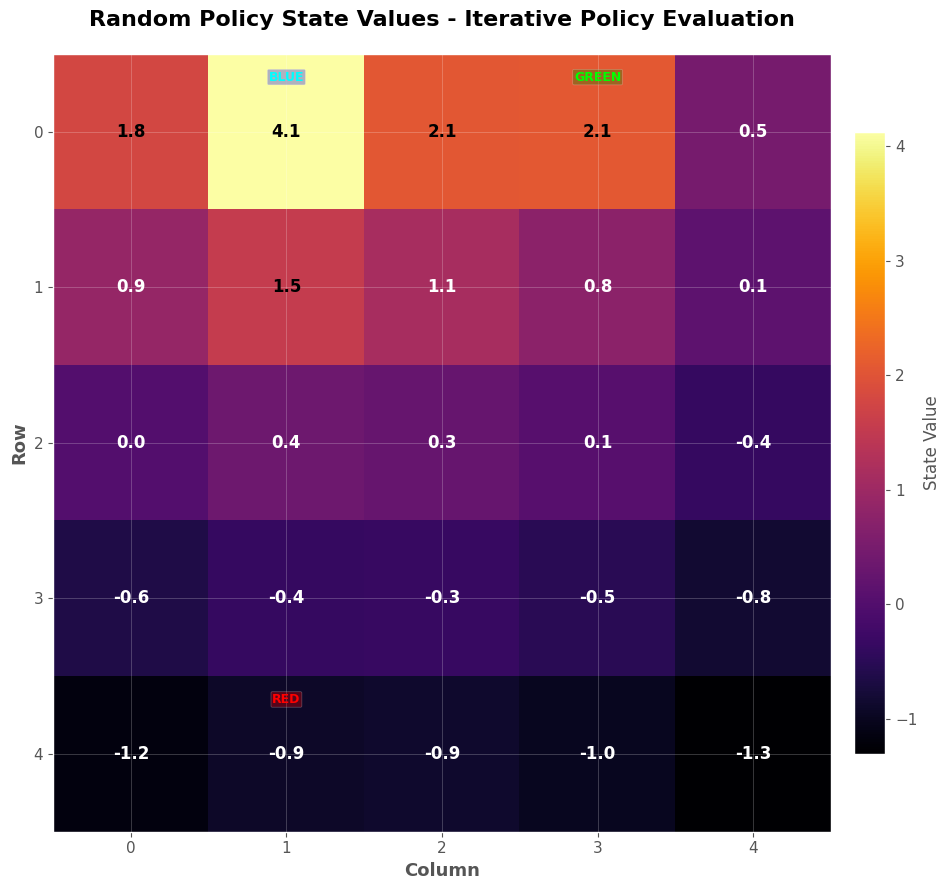


Analysis of Random Policy Results:
Top 5 highest-value states under random policy:
  1. State (0, 1): 4.129
  2. State (0, 3): 2.089
  3. State (0, 2): 2.068
  4. State (0, 0): 1.790
  5. State (1, 1): 1.540

Special state values under random policy:
  Blue state (0, 1): 4.129
  Green state (0, 3): 2.089
  Red state (4, 1): -0.917


In [51]:
#iterative policy evaluation
RandomPolicyValues = IterativePolicyEvaluation(Environment, Iterations=1000, Threshold=1e-6)

# results display
print("\nRandom Policy State Values (Tabular Format):")
PrintValuesAsGrid(RandomPolicyValues, Title="Random Policy State Values")


PlotHeatmapInferno(RandomPolicyValues, "Random Policy State Values - Iterative Policy Evaluation",
                   Environment, ShowSpecialStates=True)

# a look at the results
print("\nAnalysis of Random Policy Results:")
SortedStates = sorted(RandomPolicyValues.items(), key=lambda x: x[1], reverse=True)
print("Top 5 highest-value states under random policy:")
for i, (State, Value) in enumerate(SortedStates[:5]):
    print(f"  {i+1}. State {State}: {Value:.3f}")

print(f"\nSpecial state values under random policy:")
print(f"  Blue state {Environment.BlueState}: {RandomPolicyValues[Environment.BlueState]:.3f}")
print(f"  Green state {Environment.GreenState}: {RandomPolicyValues[Environment.GreenState]:.3f}")
print(f"  Red state {Environment.RedState}: {RandomPolicyValues[Environment.RedState]:.3f}")

Finding the optimal policy using value iteration algorithm...

Starting value iteration with threshold 1e-06
Value iteration converged after 302 iterations with delta = 9.86e-07

Optimal Policy State Values (Tabular Format):

Optimal Policy State Values:
----------------------------------------------
|  21.00 |  22.10 |  21.00 |  19.60 |  18.62 |
----------------------------------------------
|  19.95 |  21.00 |  19.95 |  18.95 |  18.00 |
----------------------------------------------
|  18.95 |  19.95 |  18.95 |  18.00 |  17.10 |
----------------------------------------------
|  18.00 |  18.95 |  18.00 |  17.10 |  16.25 |
----------------------------------------------
|  17.10 |  18.00 |  17.10 |  16.25 |  15.43 |
----------------------------------------------


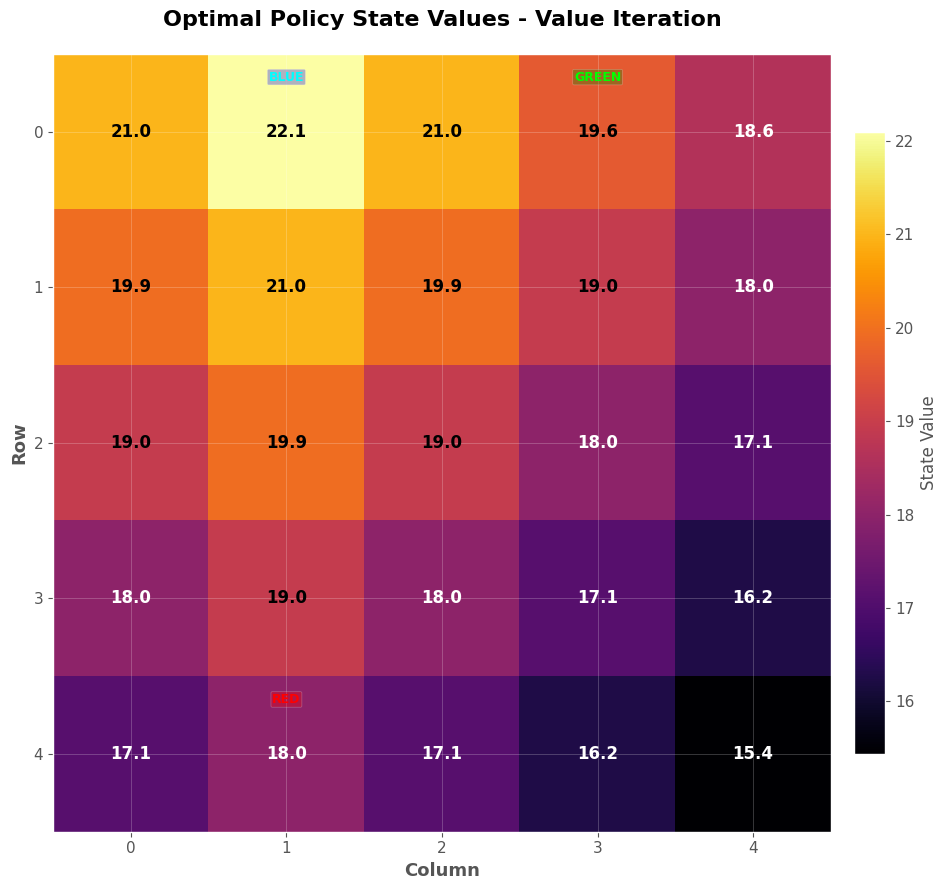


Optimal Policy (Action Directions):
--------------------------
|  →  |  ↑  |  ←  |  ↑  |  ←  |
--------------------------
|  ↑  |  ↑  |  ↑  |  ←  |  ←  |
--------------------------
|  ↑  |  ↑  |  ↑  |  ↑  |  ↑  |
--------------------------
|  ↑  |  ↑  |  ↑  |  ↑  |  ↑  |
--------------------------
|  ↑  |  ↑  |  ↑  |  ↑  |  ↑  |
--------------------------

Analysis of Optimal Policy Results:
The top 5 highest-value states under optimal policy:
  1. State (0, 1): 22.102
  2. State (0, 0): 20.997
  3. State (0, 2): 20.997
  4. State (1, 1): 20.997
  5. State (1, 0): 19.947

Special state values under optimal policy:
  Blue state (0, 1): 22.102
  Green state (0, 3): 19.602
  Red state (4, 1): 18.003


In [52]:

OptimalValues, OptimalPolicy = ValueIteration(Environment, Threshold=1e-6, MaxIterations=10000)

# Displaying optimal values
print("\nOptimal Policy State Values (Tabular Format):")
PrintValuesAsGrid(OptimalValues, Title="Optimal Policy State Values")


PlotHeatmapInferno(OptimalValues, "Optimal Policy State Values - Value Iteration",
                   Environment, ShowSpecialStates=True)

# Displayong the learned optimal policy
PrintPolicyGrid(OptimalPolicy)

# A look at the optimal policy results
print("\nAnalysis of Optimal Policy Results:")
SortedOptimalStates = sorted(OptimalValues.items(), key=lambda x: x[1], reverse=True)
print("The top 5 highest-value states under optimal policy:")
for i, (State, Value) in enumerate(SortedOptimalStates[:5]):
    print(f"  {i+1}. State {State}: {Value:.3f}")

print(f"\nSpecial state values under optimal policy:")
print(f"  Blue state {Environment.BlueState}: {OptimalValues[Environment.BlueState]:.3f}")
print(f"  Green state {Environment.GreenState}: {OptimalValues[Environment.GreenState]:.3f}")
print(f"  Red state {Environment.RedState}: {OptimalValues[Environment.RedState]:.3f}")


Comparing the policy performances


State    Random     Optimal    Improvement  % Gain    
-------------------------------------------------------
(0, 0)   1.790      20.997     19.207       1072.8    %
(0, 1)   4.129      22.102     17.973       435.3     %
(0, 2)   2.068      20.997     18.929       915.4     %
(0, 3)   2.089      19.602     17.514       838.5     %
(0, 4)   0.480      18.622     18.143       3781.7    %
(1, 1)   1.540      20.997     19.457       1263.2    %
(2, 2)   0.281      18.950     18.669       6646.9    %
(3, 3)   -0.506     17.102     17.608       3481.9    %
(4, 1)   -0.917     18.003     18.920       2062.3    %
(4, 4)   -1.308     15.435     16.743       1279.8    %

Overall Performance Summary:
Total value under random policy: 9.646
Total value under optimal policy: 192.809
Total improvement: 183.164
Relative improvement: 1898.9%


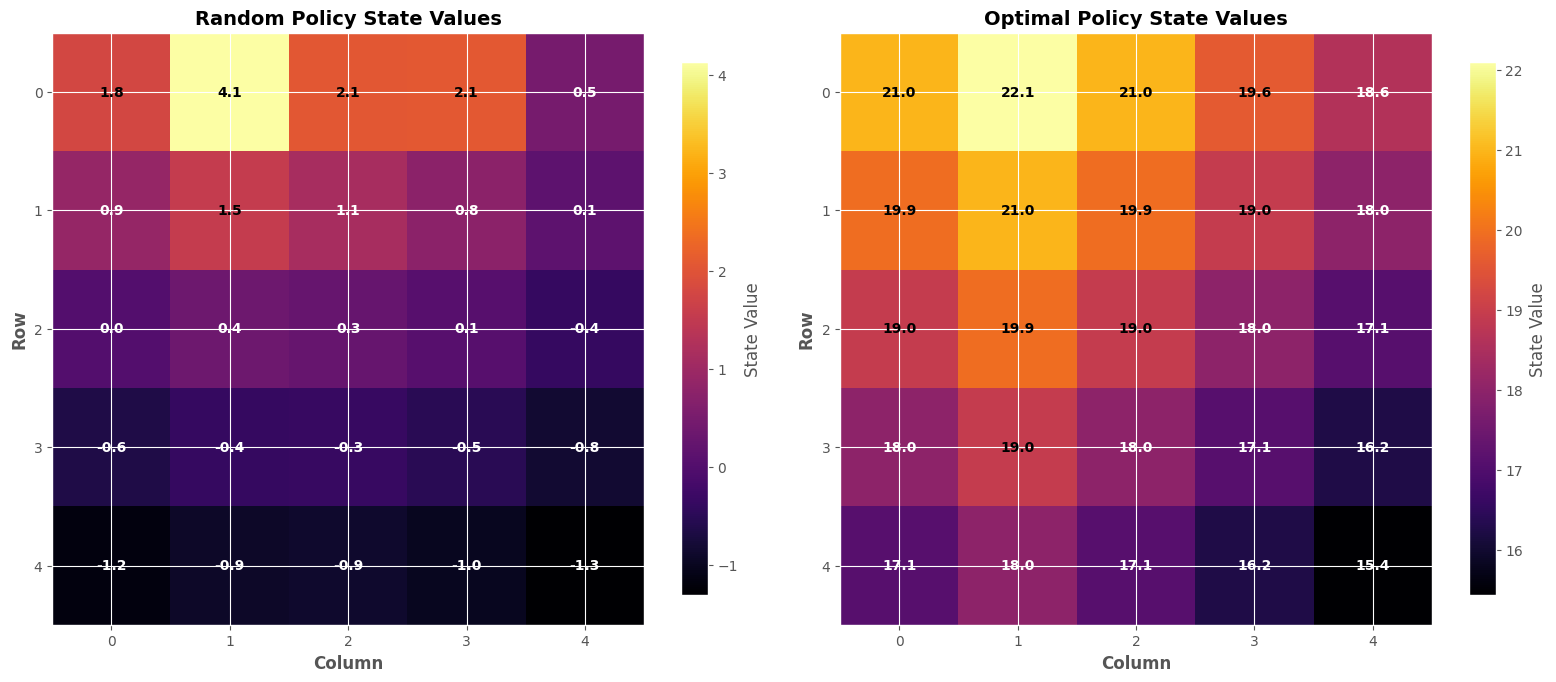

In [53]:
# a comparison table
ComparisonStates = [(0,0), (0,1), (0,2), (0,3), (0,4),
                   (1,1), (2,2), (3,3), (4,1), (4,4)]

print(f"\n{'State':<8} {'Random':<10} {'Optimal':<10} {'Improvement':<12} {'% Gain':<10}")
print("-" * 55)

TotalRandomValue = 0
TotalOptimalValue = 0

for State in ComparisonStates:
    RandomVal = RandomPolicyValues[State]
    OptimalVal = OptimalValues[State]
    Improvement = OptimalVal - RandomVal
    PercentGain = (Improvement / abs(RandomVal) * 100) if RandomVal != 0 else float('inf')

    TotalRandomValue += RandomVal
    TotalOptimalValue += OptimalVal

    print(f"{str(State):<8} {RandomVal:<10.3f} {OptimalVal:<10.3f} {Improvement:<12.3f} {PercentGain:<10.1f}%")

TotalImprovement = TotalOptimalValue - TotalRandomValue
print(f"\nOverall Performance Summary:")
print(f"Total value under random policy: {TotalRandomValue:.3f}")
print(f"Total value under optimal policy: {TotalOptimalValue:.3f}")
print(f"Total improvement: {TotalImprovement:.3f}")
print(f"Relative improvement: {(TotalImprovement/abs(TotalRandomValue)*100):.1f}%")

# A side-by-side comparison
plt.figure(figsize=(16, 7))

# Random policy heatmap
plt.subplot(1, 2, 1)
RandomGrid = np.zeros((5, 5))
for (i, j), v in RandomPolicyValues.items():
    RandomGrid[i, j] = v

Im1 = plt.imshow(RandomGrid, cmap='inferno', aspect='equal')
plt.colorbar(Im1, label='State Value', shrink=0.8)
plt.title('Random Policy State Values', fontsize=14, fontweight='bold')

MaxRandom = np.max(RandomGrid)
MinRandom = np.min(RandomGrid)
RangeRandom = MaxRandom - MinRandom

for i in range(5):
    for j in range(5):
        Value = RandomGrid[i, j]
        NormalizedVal = (Value - MinRandom) / RangeRandom if RangeRandom > 0 else 0
        Color = 'white' if NormalizedVal < 0.5 else 'black'
        plt.text(j, i, f"{Value:.1f}", ha='center', va='center',
                color=Color, fontweight='bold', fontsize=10)

plt.xlabel('Column', fontweight='bold')
plt.ylabel('Row', fontweight='bold')
plt.xticks(range(5))
plt.yticks(range(5))

# Optimal policy heatmap
plt.subplot(1, 2, 2)
OptimalGrid = np.zeros((5, 5))
for (i, j), v in OptimalValues.items():
    OptimalGrid[i, j] = v

Im2 = plt.imshow(OptimalGrid, cmap='inferno', aspect='equal')
plt.colorbar(Im2, label='State Value', shrink=0.8)
plt.title('Optimal Policy State Values', fontsize=14, fontweight='bold')

MaxOptimal = np.max(OptimalGrid)
MinOptimal = np.min(OptimalGrid)
RangeOptimal = MaxOptimal - MinOptimal

for i in range(5):
    for j in range(5):
        Value = OptimalGrid[i, j]
        NormalizedVal = (Value - MinOptimal) / RangeOptimal if RangeOptimal > 0 else 0
        Color = 'white' if NormalizedVal < 0.5 else 'black'
        plt.text(j, i, f"{Value:.1f}", ha='center', va='center',
                color=Color, fontweight='bold', fontsize=10)

plt.xlabel('Column', fontweight='bold')
plt.ylabel('Row', fontweight='bold')
plt.xticks(range(5))
plt.yticks(range(5))

plt.tight_layout()
plt.show()



The blue state at position (0,1) consistently achieves the highest value under both policies due to its substantial +5 reward, while the green state at (0,3) also shows strong value thanks to its +2.5 reward and teleportation ability. Nearby states benefit from proximity effects, creating directional flows that guide the optimal policy toward more rewarding areas. States located near boundaries tend to have lower values, affected by movement restrictions and a -0.5 penalty. Value iteration proves highly effective in pinpointing a globally optimal strategy, and the inferno colormap plays a critical role in visualizing gradients across the value landscape. The results are in line with RL, where high-reward states naturally dominate, optimal policies shape efficient paths, and the discount factor (γ = 0.95) amplifies the influence of proximity—while penalties at borders help define navigational barriers.